In [1]:
import pandas as pd, numpy as np
import pathlib, codecs
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta,date
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.preprocessing import MinMaxScaler
import optuna
plt.rcParams['font.sans-serif']='MS Mincho'
%matplotlib inline

In [2]:
data_n=pd.read_csv('processed_data.csv',
                 index_col=0,
                 parse_dates=["transaction_date"])

In [3]:
consumption_sum = data_n.groupby('transaction_date')['CASHING_SUM'].sum().reset_index()
MAX = consumption_sum.CASHING_SUM.max()
consumption_sum['dow'] = consumption_sum['transaction_date'].dt.dayofweek
consumption_sum['woy'] = consumption_sum['transaction_date'].dt.isocalendar().week
consumption_sum['day'] = consumption_sum['transaction_date'].dt.day
consumption_sum['month'] = consumption_sum['transaction_date'].dt.month
consumption_sum['year'] = consumption_sum['transaction_date'].dt.year
consumption_sum['holiday'] = 0
consumption_sum.loc[consumption_sum['dow'].isin([5, 6]), 'holiday'] = 1
consumption_sum['is_year_start'] = consumption_sum['transaction_date'].dt.is_year_start*1
consumption_sum['is_year_end'] = consumption_sum['transaction_date'].dt.is_year_end*1
consumption_sum['is_quarter_start'] = consumption_sum['transaction_date'].dt.is_quarter_start*1
consumption_sum['is_quarter_end'] = consumption_sum['transaction_date'].dt.is_quarter_end*1
consumption_sum['is_month_start'] = consumption_sum['transaction_date'].dt.is_month_start*1
consumption_sum['is_month_end'] = consumption_sum['transaction_date'].dt.is_month_end*1
consumption_sum.set_index('transaction_date', inplace=True)
# 删除一些时间特征，使得结果变得更差了

In [4]:
train_set = consumption_sum[:'2021-06-26']
test_set = consumption_sum['2021-06-27':timedelta(90)+datetime(2021,6,26)]
train_X, train_y = train_set.drop('CASHING_SUM',axis=1), train_set['CASHING_SUM']
test_X, test_y = test_set.drop('CASHING_SUM',axis=1), test_set['CASHING_SUM']

In [5]:
from xgboost import XGBRegressor as XGBR
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [9]:
def objectiveXB(trial):
    # train_X, train_y = train_set.drop('CASHING_SUM',axis=1), train_set['CASHING_SUM']
    # test_X, test_y = test_set.drop('CASHING_SUM',axis=1), test_set['CASHING_SUM']
    param = {
        # 'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_categorical('n_estimators', [90,95,100,150,200,300,400,500,800,1000]),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = XGBR(**param)  
    model.fit(train_X.values,train_y,eval_set=[(test_X.values,test_y)],verbose=False)
    preds = model.predict(test_X.values)
    mape = MAPE(test_y, preds)
    return mape
study = optuna.create_study(direction='minimize')
study.optimize(objectiveXB, n_trials=50) # trial 实验数
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()
optuna.visualization.plot_param_importances(study).show()
params=study.best_params

[I 2022-01-12 15:30:54,278] A new study created in memory with name: no-name-bf26b887-cc39-4074-aa1e-4a1bf2dbdf64
[I 2022-01-12 15:30:54,623] Trial 0 finished with value: 0.3179823964402652 and parameters: {'lambda': 0.0011970723327863497, 'alpha': 3.4561138730386296, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 800, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 259}. Best is trial 0 with value: 0.3179823964402652.
[I 2022-01-12 15:30:54,728] Trial 1 finished with value: 0.2538061700940315 and parameters: {'lambda': 6.134550933878562, 'alpha': 0.03497924992081729, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 200, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 101}. Best is trial 1 with value: 0.2538061700940315.
[I 2022-01-12 15:30:55,088] Trial 2 finished with value: 0.2827967346901978 and parameters: {'lambda': 0.08995694402823336, 'alpha': 0.5075560787889011, 'colsample_bytree': 1.0, 'subs

[I 2022-01-12 15:31:01,599] Trial 22 finished with value: 0.17252373850261965 and parameters: {'lambda': 0.0038269741423901655, 'alpha': 0.6540229021806844, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.008, 'n_estimators': 300, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 3}. Best is trial 13 with value: 0.15052626506709835.
[I 2022-01-12 15:31:01,841] Trial 23 finished with value: 0.15679763004652392 and parameters: {'lambda': 0.008403258692739007, 'alpha': 0.05108210028446513, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 300, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 42}. Best is trial 13 with value: 0.15052626506709835.
[I 2022-01-12 15:31:02,107] Trial 24 finished with value: 0.17150007391030705 and parameters: {'lambda': 0.07574746572319226, 'alpha': 0.05207134114076001, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 400, 'max_depth': 11, 'random_state': 48, 'min_chi

[I 2022-01-12 15:31:16,124] Trial 45 finished with value: 0.189107608545037 and parameters: {'lambda': 0.013507899739594688, 'alpha': 0.004591389605026994, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 84}. Best is trial 13 with value: 0.15052626506709835.
[I 2022-01-12 15:31:16,694] Trial 46 finished with value: 0.19866297448145262 and parameters: {'lambda': 0.001634995383523078, 'alpha': 0.015327915901200861, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.009, 'n_estimators': 800, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 58}. Best is trial 13 with value: 0.15052626506709835.
[I 2022-01-12 15:31:16,776] Trial 47 finished with value: 0.25632629450010785 and parameters: {'lambda': 1.667609229787907, 'alpha': 0.023022075137539483, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 90, 'max_depth': 11, 'random_state': 48, 'min_chi

In [10]:
params

{'lambda': 0.008843577288202694,
 'alpha': 0.01850229171980794,
 'colsample_bytree': 0.9,
 'subsample': 0.4,
 'learning_rate': 0.02,
 'n_estimators': 400,
 'max_depth': 7,
 'random_state': 48,
 'min_child_weight': 3}

<function matplotlib.pyplot.show(close=None, block=None)>

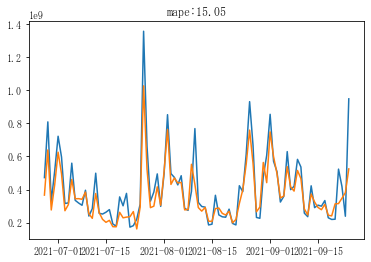

In [13]:
model = XGBR(**params)  
model.fit(train_X.values,train_y)
preds = model.predict(test_X.values)
mape = MAPE(test_y, preds)
plt.title(f"mape:{round(mape*100,2)}")
plt.plot(test_y.index,test_y.values)
plt.plot(test_y.index,preds)
plt.show